In [38]:
def load_images(container_path, description=None, categories=None,
               load_content=True, shuffle=True, target_size=None, gray=True, flatten=True, random_state=0):
    from sklearn.utils import Bunch, check_random_state
    import cv2
    from os import environ, listdir, makedirs
    from os.path import dirname, exists, expanduser, isdir, join, splitext
    import numpy as np
    """
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    description : string or unicode, optional (default=None)
        A paragraph describing the characteristic of the dataset: its source,
        reference, etc.
    categories : A collection of strings or None, optional (default=None)
        If None (default), load all the categories. If not None, list of
        category names to load (other categories ignored).
    load_content : boolean, optional (default=True)
        Whether to load or not the content of the different files. If true a
        'data' attribute containing the text information is present in the data
        structure returned. If not, a filenames attribute gives the path to the
        files.
    shuffle : bool, optional (default=True)
        Whether or not to shuffle the data: might be important for models that
        make the assumption that the samples are independent and identically
        distributed (i.i.d.), such as stochastic gradient descent.
    encoding : string or None (default is None)
        If None, do not try to decode the content of the files (e.g. for images
        or other non-text content). If not None, encoding to use to decode text
        files to Unicode if load_content is True.
    decode_error : {'strict', 'ignore', 'replace'}, optional
        Instruction on what to do if a byte sequence is given to analyze that
        contains characters not of the given `encoding`. Passed as keyword
        argument 'errors' to bytes.decode.
    random_state : int, RandomState instance or None (default=0)
        Determines random number generation for dataset shuffling. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    data : Bunch
        Dictionary-like object, the interesting attributes are: either
        data, the raw text data to learn, or 'filenames', the files
        holding it, 'target', the classification labels (integer index),
        'target_names', the meaning of the labels, and 'DESCR', the full
        description of the dataset.
    """
    target = []
    target_names = []
    filenames = []

    folders = [f for f in sorted(listdir(container_path))
               if isdir(join(container_path, f))]

    if categories is not None:
        folders = [f for f in folders if f in categories]

    for label, folder in enumerate(folders):
        target_names.append(folder)
        folder_path = join(container_path, folder)
        documents = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        target.extend(len(documents) * [label])
        filenames.extend(documents)

    # convert to array for fancy indexing
    filenames = np.array(filenames)
    target = np.array(target)

    if shuffle:
        random_state = check_random_state(random_state)
        indices = np.arange(filenames.shape[0])
        random_state.shuffle(indices)
        filenames = filenames[indices]
        target = target[indices]

    if load_content:
        data = []
        for filename in filenames:
            img = cv2.imread(filename)
            if target_size:
                img = cv2.resize(img, target_size)
            if gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
            if flatten:
                img = img.flatten()
            data.append(img)
        data = np.array(data)
        return Bunch(data=data,
                     filenames=filenames,
                     target_names=target_names,
                     target=target,
                     DESCR=description)

    return Bunch(filenames=filenames,
                 target_names=target_names,
                 target=target,
                 DESCR=description)


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline                   
from time import time

from glob import glob
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [40]:
TRAINING_DIR = 'data/data_new/'
TESTING_DIR = 'data/data_test'
IMAGE_SIZE = 64
RANDOM_STATE = 15
PIECE_NAMES = [item[14:] for item in sorted(glob(TRAINING_DIR + "/*"))]

In [41]:
dataset = load_images(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE))
X_train, y_train = dataset.data, dataset.target
target_names = dataset.target_names
n_classes = len(target_names)

In [42]:
_test = load_images(TESTING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE))
X_test, y_test = _test.data, _test.target

In [43]:
n_components = 50
h, w = IMAGE_SIZE, IMAGE_SIZE
print("Extracting the top %d eigenpieces from %d pieces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 50 eigenpieces from 1029 pieces
done in 0.259s


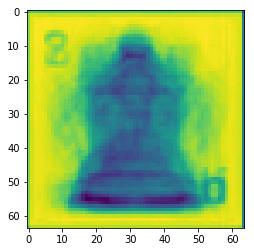

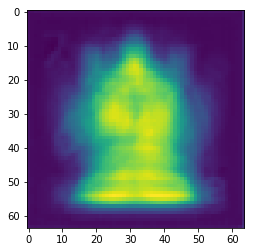

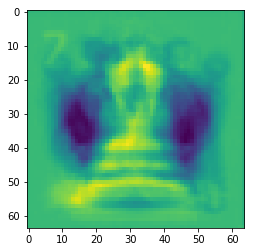

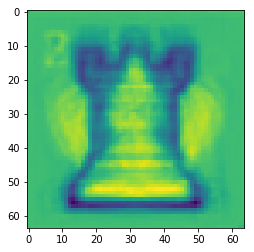

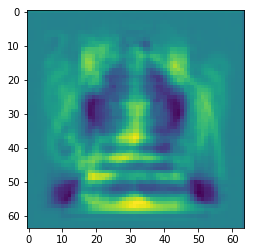

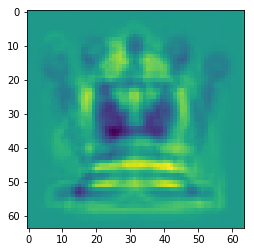

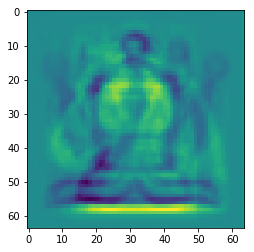

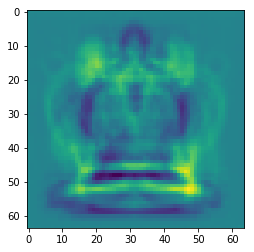

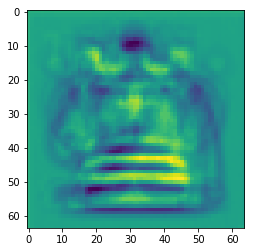

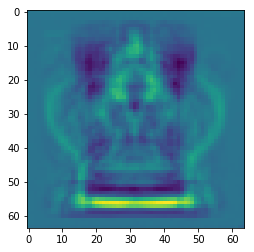

In [44]:
# Plotting the eigenpieces
for piece in pca.components_[:10]:
    gray = np.reshape(piece, (IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(gray)
    plt.show()

In [45]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenpieces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenpieces orthonormal basis
done in 0.032s


In [46]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 15.495s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [47]:
t0 = time()
y_pred = clf.predict(X_test_pca)

In [48]:
print(target_names)
print("F1 Score", f1_score(y_test, y_pred, average='micro'))

['BISHOP', 'BLANK', 'KING', 'KNIGHT', 'PAWN', 'QUEEN', 'ROOK']
F1 Score 0.75


In [49]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

      BISHOP       0.52      0.75      0.62        16
       BLANK       1.00      1.00      1.00        16
        KING       0.71      0.83      0.77        12
      KNIGHT       0.80      0.75      0.77        16
        PAWN       0.69      0.69      0.69        16
       QUEEN       0.73      0.67      0.70        12
        ROOK       1.00      0.56      0.72        16

   micro avg       0.75      0.75      0.75       104
   macro avg       0.78      0.75      0.75       104
weighted avg       0.78      0.75      0.75       104

[[12  0  0  0  4  0  0]
 [ 0 16  0  0  0  0  0]
 [ 0  0 10  1  0  1  0]
 [ 3  0  1 12  0  0  0]
 [ 1  0  1  2 11  1  0]
 [ 3  0  0  0  1  8  0]
 [ 4  0  2  0  0  1  9]]
0.75
